In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline

In [2]:
!ls

CO2_2016_forecast.pro
GCP_Emiss.txt
HadISST1.1_sst_1870on_1dg_anm6190_ninos_save
Nino_34.txt
Nino_34_1870.txt
README.md
Rebuilding_Betts2016.ipynb
monthly_mlo.csv
nino34_combined_realisations.dat


## Load nino34

In [5]:
nino = pd.read_fwf('Nino_34_1870.txt', header=None, delimiter=' ').set_index([0,1]).astype(float).replace(-99.990, np.nan).median(axis=1)

In [6]:
nino=nino.shift(4) #make april to march

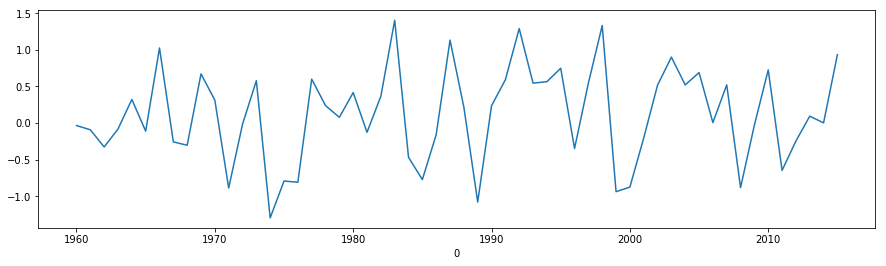

In [7]:
nino_ym = nino.unstack().mean(axis=1).loc[1960:2015]
nino_ym = nino_ym - nino_ym.loc[1961:1990].mean()
nino_ym.plot(figsize=(15,4))

## Load emissions

In [9]:
emissions = pd.read_csv('GCP_Emiss.txt', sep='\t', header=None).set_index(0).loc[1960:2015]

In [11]:
emissions.tail()

,1,2
0,,
2009,8.74,0.71
2010,9.17,0.83
2011,9.46,0.88
2012,9.67,0.93
2013,9.86,0.89


In [12]:
emissions=emissions.sum(axis=1)

In [13]:
emissions.T[2014]=10.9
emissions.T[2015]=10.9

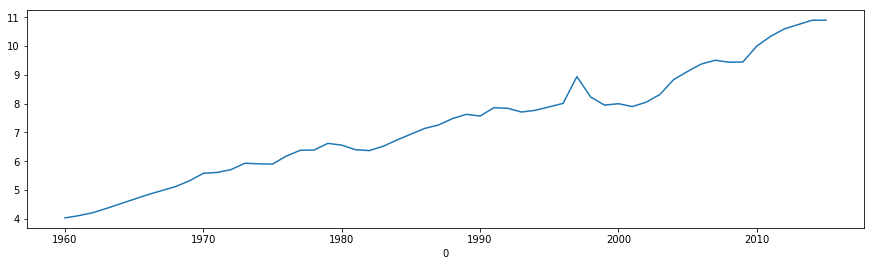

In [14]:
emissions.plot(figsize=(15,4))

## Load Mauna Loa

In [17]:
names=['Yr', 'Mn',    'Date',      'Date',     'CO2,seasonally',  'CO2,seasonally,adjusted' ,     'fit,  seasonally', 'fit, seasonally,adjusted'       ,'CO2, seasonally,filled','CO2, seasonally,adjusted fit,filled,adjusted filled']
ML = pd.read_csv('monthly_mlo.csv', skiprows=57, header=None).set_index([0,1]).astype(float).replace(-99.990, np.nan)

In [18]:
ML.columns=names[2:]

In [19]:
ML.head()

Date       Date  CO2,seasonally  CO2,seasonally,adjusted  \
0    1                                                                
1958 1  21200.0  1958.0411             NaN                      NaN   
     2  21231.0  1958.1260             NaN                      NaN   
     3  21259.0  1958.2027          315.69                   314.41   
     4  21290.0  1958.2877          317.46                   315.15   
     5  21320.0  1958.3699          317.51                   314.72   

        fit,  seasonally  fit, seasonally,adjusted  CO2, seasonally,filled  \
0    1                                                                       
1958 1               NaN                       NaN                     NaN   
     2               NaN                       NaN                     NaN   
     3            316.16                    314.88                  315.69   
     4            317.27                    314.96                  317.46   
     5            317.83                    315.05                  317.51   

        CO2, seasonally,adjusted fit,filled,adjusted filled  
0    1                                                       
1958 1                                                NaN    
     2                                                NaN    
     3                                             314.41    
     4                                             315.15    
     5                                             314.72

In [20]:
ML=ML['CO2,seasonally'].unstack()

In [21]:
ML_ym = ML.mean(axis=1).loc[1959:2015]

In [22]:
ML_ym.head()

0
1959    315.975000
1960    316.908333
1961    317.638333
1962    318.449167
1963    318.994167
dtype: float64

In [23]:
ML_incr = ML_ym.diff().dropna()

# Model

In [24]:
alpha1 = -0.132 #ppm yr-1
alpha2 = 0.415 # ppm yr-1 C-1
alpha3 = 0.237 # ppm GtC-1


def model(nino, epsilon):
    dco2 = alpha1 + alpha2 * nino + alpha3 * epsilon
    return dco2

In [25]:
dco2 = model(nino_ym, emissions)

In [26]:
dco2.tail()

0
2011    2.049817
2012    2.277644
2013    2.454398
2014    2.451993
2015    2.838769
dtype: float64

## Figure 1

In [27]:
def plot_vlines(volcanoes=True, nino=True):
    volcanolist = [1983,1991,1993]
    ninolist = [1966,1973,1983,1988,1998,2016]
    plotlist = []
    if volcanoes:
        plotlist = plotlist + volcanolist
    if nino:
        plotlist = plotlist + ninolist
    for v in plotlist:
        plt.axvline(x=v,color='gray',ls='--')

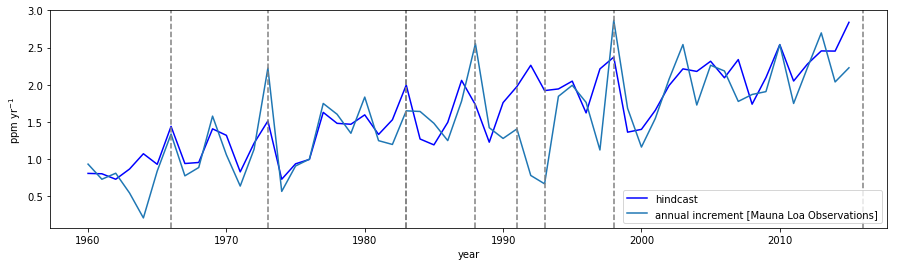

In [29]:
dco2.plot(figsize=(15,4),label='hindcast', color='blue')
ML_incr.plot(label='annual increment [Mauna Loa Observations]')
plt.legend()
plt.ylabel('ppm yr$^{-1}$')
plt.xlabel('year')
plot_vlines()

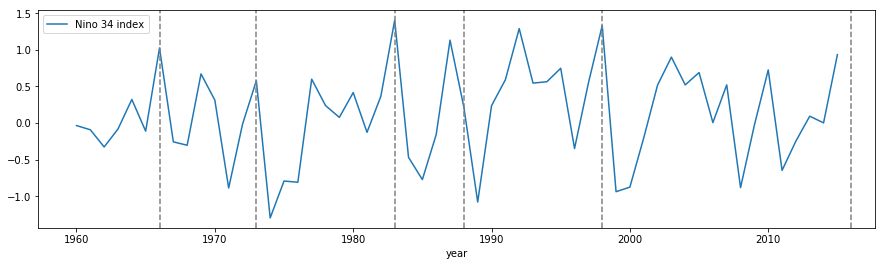

In [30]:
nino_ym.plot(figsize=(15,4),label='Nino 34 index')
plt.xlabel('year')
plot_vlines(volcanoes=False)
plt.legend()

# Comparison of forecast and obs

In [31]:
#from xskillscore import mae, rmse, mse, pearson_r

In [32]:
from climpred.stats import xr_rm_trend

from scipy.stats import pearsonr 
from sklearn.metrics import mean_absolute_error, mean_squared_error

def root_mean_squared_error(a,b):
    return np.sqrt(mean_squared_error(a,b))

metrics=[root_mean_squared_error,mean_absolute_error, mean_squared_error,pearsonr]

In [33]:
def comparison(metric=pearsonr):
    return metric(ML_incr,dco2)

In [34]:
for metric in metrics:
    print(metric.__name__,comparison(metric=metric))

root_mean_squared_error 0.43013925053750235
mean_absolute_error 0.30194004042658534
mean_squared_error 0.1850197748529642
pearsonr (0.7482060644688359, 3.404312964162011e-11)


## detrend

In [303]:
def detrend(series):
    s,i=np.polyfit(series.index,series.values,1)
    return series-s*series.index-i

In [304]:
detrended_ML_incr = detrend(ML_incr)
detrended_dco2 = detrend(dco2)

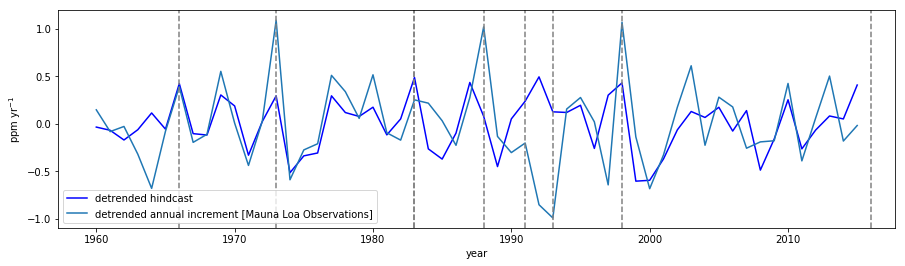

In [305]:
detrended_dco2.plot(figsize=(15,4),label='detrended hindcast', color='blue')
detrended_ML_incr.plot(label='detrended annual increment [Mauna Loa Observations]')
plt.legend()
plt.ylabel('ppm yr$^{-1}$')
plt.xlabel('year')
plot_vlines()

In [306]:
def detrended_comparison(metric=pearsonr):
    return metric(detrended_ML_incr,detrended_dco2)

In [307]:
for metric in metrics:
    print(metric.__name__,detrended_comparison(metric=metric))

root_mean_squared_error 0.41125975543661375
mean_absolute_error 0.29091401326562316
mean_squared_error 0.16913458644178334
pearsonr (0.3918057264965229, 0.002824046865551015)
